In [7]:
from pathlib import Path
import meshio
from mesh_handler import xdmf_to_meshes, meshes_to_xdmf, vtu_to_mesh, mesh_to_vtu,  accessing_mesh_data, create_mock_mesh
from preprocessing_utils import torch_input_edges, torch_input_edges, get_X_y
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [8]:
#Example use

# after executing preprocessing_utils.py with 4Students_AnXplore03 in the same directory
# a folder named "data_cleaned" will be created with the preprocessed mesh files
# the function get_X_y can be used to get the input and output data of mesh_id

#retrieve the list of all the mesh_ids
CWD = Path.cwd()
data_path = CWD / "data_cleaned"
xdmf_files = list(data_path.glob("*.pth"))
mesh_ids = [xdmf_file.name.split("_")[1].split(".")[0] for xdmf_file in xdmf_files]
print(mesh_ids)
mesh_id = mesh_ids[0]

X_nodes, X_edges, y = get_X_y(mesh_id, time_step=0)
print(X_nodes.shape)
print(X_edges.shape)
print(y.shape)

['137', '19', '25', '31', '42-3', '196-2', '42-2', '136', '120', '134', '26', '196-1', '42-1', '6', '135', '121', '23', '2', '3', '1', '34', '140', '197', '183', '168-2', '155', '157', '180', '194', '209', '208', '44', '195', '181', '168-1', '142', '152', '40', '185', '191', '219', '193-2', '55', '153', '151', '192', '193-1', '187', '178', '175', '161', '203', '217', '144-2', '202', '186-1', '148', '174', '162', '189', '214', '200', '9-1', '215', '188', '186-2', '177', '173', '54-1', '211', '205', '182-2', '182-3', '204', '210', '199', '172', '166', '158', '170', '164', '54-2', '206', '212', '182-1', '213', '207', '165', '171', '159', '163-2', '119-1', '11', '117', '163-1', '129', '119-2', '128', '138', '198-2', '139', '198-1', '28']
torch.Size([12567, 7])
torch.Size([2, 79366])
torch.Size([12567, 4])


In [ ]:
def compute_edge_weights(edge_index, X):
    # Extraire les indices des nœuds source et cible
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]

    # Obtenir les coordonnées des nœuds source et cible
    source_coords = X[source_nodes,:3]  # Coordonnées (x, y, z) des nœuds source
    target_coords = X[target_nodes,:3]  # Coordonnées (x, y, z) des nœuds cible

    # Calcul de la distance euclidienne entre les nœuds source et cible
    distances = torch.norm(source_coords - target_coords, dim=1)

    # Éviter la division par zéro en ajoutant une petite valeur epsilon
    epsilon = 1e-8
    edge_weights = 1.0 / (distances + epsilon)

    return edge_weights

## data explo

In [9]:
mesh_id = mesh_ids[0]
data = torch.load(data_path / f"mesh_{mesh_id}.pth")
X_nodes_all, X_edges = data["nodes"], data["edges"]

/var/folders/m7/fyj040hx1x1fw7ttkzlnffgr0000gn/T/ipykernel_71532/1232847321.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path / f"mesh_{mesh_id

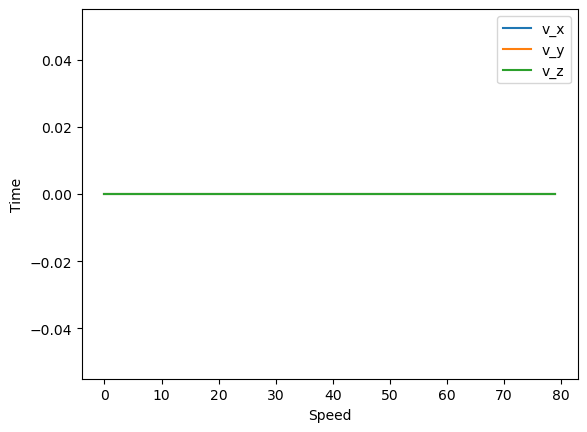

In [10]:
#speeds at node 800 across all time steps
plt.plot(X_nodes_all[:, 800, 3], label="v_x")
plt.plot(X_nodes_all[:, 800, 4], label="v_y")
plt.plot(X_nodes_all[:, 800, 5], label="v_z")
plt.xlabel("Speed")
plt.ylabel("Time")
plt.legend();

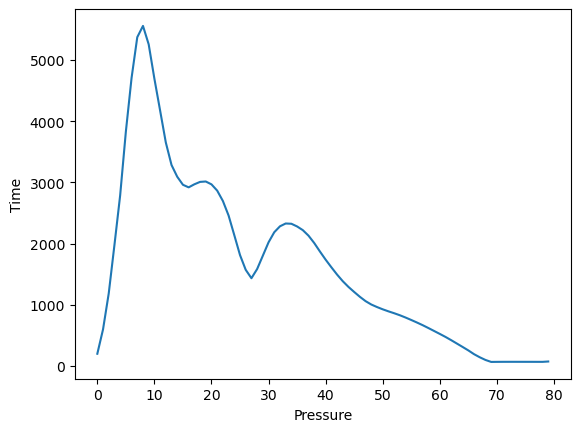

In [11]:
#pressure at node 800 across all time steps
plt.plot(X_nodes_all[:, 800, 6])
plt.xlabel("Pressure")
plt.ylabel("Time");

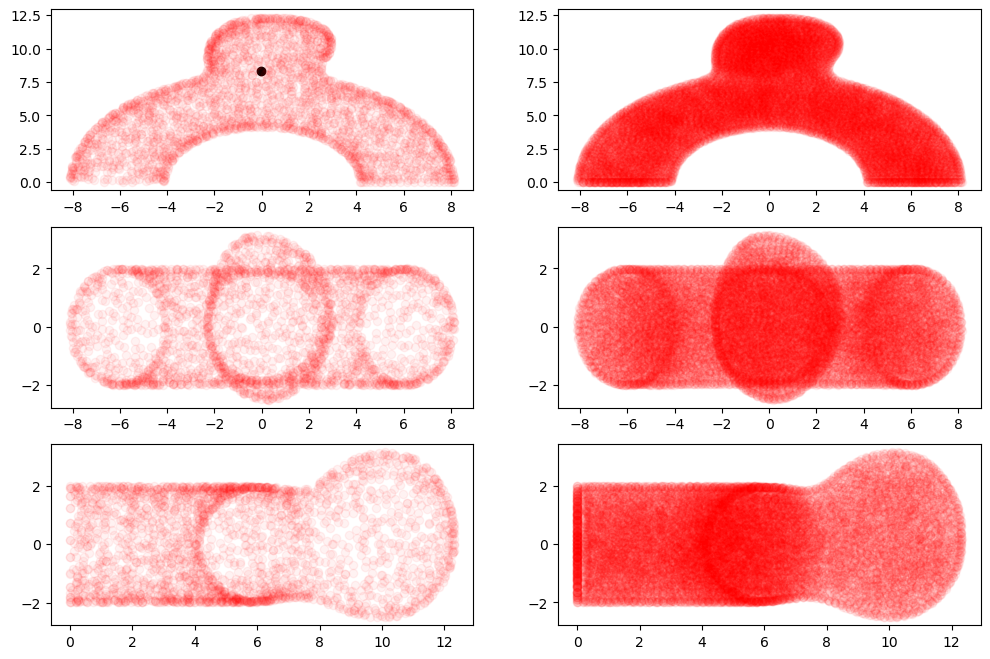

In [12]:
X_nodes_init = X_nodes_all[0]
velocities = torch.norm(X_nodes_init[:,3:6], p=2, dim=1)
border = torch.where(velocities < 1e-10)[0]
fig, ax = plt.subplots(3, 2, figsize=(12, 8))
sub_border = border[::2]
ax[0,0].plot(X_nodes_init[800, 0], X_nodes_init[800, 1], "ko")
ax[0,0].plot(X_nodes_init[sub_border, 0], X_nodes_init[sub_border, 1], "ro", alpha=0.05)
ax[0,1].plot(X_nodes_init[:, 0], X_nodes_init[:, 1], "ro", alpha=0.05)
ax[1,0].plot(X_nodes_init[sub_border, 0], X_nodes_init[sub_border, 2], "ro", alpha=0.05)
ax[1,1].plot(X_nodes_init[:, 0], X_nodes_init[:, 2], "ro", alpha=0.05);
ax[2,0].plot(X_nodes_init[sub_border, 1], X_nodes_init[sub_border, 2], "ro", alpha=0.05)
ax[2,1].plot(X_nodes_init[:, 1], X_nodes_init[:, 2], "ro", alpha=0.05);

In [13]:
def find_neighbors(edge_index, node):
    # Find all edges where the node is a source or target
    mask = (edge_index[0] == node) | (edge_index[1] == node)
    edges = edge_index[:, mask]
    
    # Extract neighbors
    neighbors = edges[1][edges[0] == node].tolist() + edges[0][edges[1] == node].tolist()
    
    # Remove duplicates and the node itself
    neighbors = list(set(neighbors) - {node})
    
    return neighbors

In [14]:
def custom_field_mesh(mesh_id: str, fields_dict, time_step: int = 0):
    meshes = xdmf_to_meshes(CWD / f"4Students_AnXplore03/AllFields_Resultats_MESH_{mesh_id}.xdmf", verbose=False)
    mesh_template = meshes[time_step]
    mesh_template.point_data = fields_dict
    return mesh_template

#Example use
if not (CWD / "vtus").exists():
    (CWD / "vtus").mkdir(exist_ok=True)

mesh_id = mesh_ids[0]
data = torch.load(data_path / f"mesh_{mesh_id}.pth")
X_nodes_all, X_edges = data["nodes"], data["edges"]
X_nodes_t = X_nodes_all[34]
velocities = torch.norm(X_nodes_t[:,3:6], p=2, dim=1)
border = torch.where(velocities < 1e-10)[0]
field = torch.zeros(X_nodes_t.shape[0], dtype=torch.float32)
field[border] = 1
dict_field = {"border": np.array(field), "velocities": np.array(velocities)}
mesh = custom_field_mesh(mesh_id, fields_dict=dict_field)
mesh_to_vtu(mesh, CWD / f"vtus/border_{mesh_id}_bordervelo.vtu")

/var/folders/m7/fyj040hx1x1fw7ttkzlnffgr0000gn/T/ipykernel_71532/4054716829.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path / f"mesh_{mesh_i

Mesh saved to /Users/leonard/Desktop/MINES/3A/IDSC/DC_flood/vtus/border_137_bordervelo.vtu


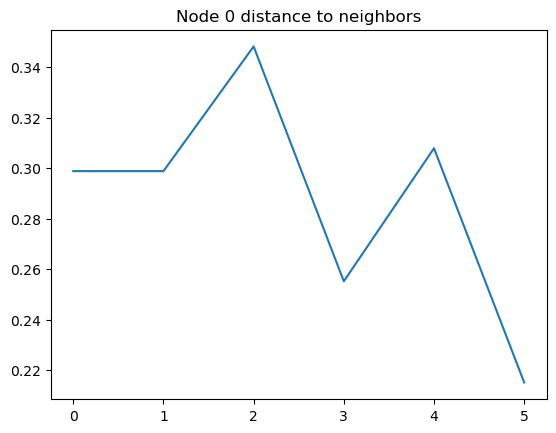

In [15]:
node = 0
neighbors = find_neighbors(X_edges, node)
plt.title(f"Node {node} distance to neighbors")
plt.plot([torch.norm(X_nodes_init[node, 0:3] - X_nodes_init[neighbor, 0:3], p=2) for neighbor in neighbors]);

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class CFDGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CFDGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index, edge_weights = None):
        x_0 = x[:,3:]
        x = self.conv1(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weights) 
        x = F.relu(x)
        x = self.conv3(x, edge_index, edge_weights)
        x = F.relu(x)
        x = self.lin(x) + x_0
        return  x



In [71]:
def train_model(model, optimizer, mesh_ids, epochs=1000):
    loss_array = []
    for epoch in range(epochs):
        mesh_id = random.choice(mesh_ids)
        time_step = random.randint(0, 34)
        X_nodes, X_edges, y = get_X_y(mesh_id, time_step=time_step)
        X_nodes = X_nodes[:,3:] # Remove the coordinates
        edge_weights = compute_edge_weights(X_edges, X_nodes)
        optimizer.zero_grad()
        out = model(X_nodes, X_edges, edge_weights)
        loss = F.mse_loss(out, y)
        loss.backward()
        optimizer.step()
        loss_array.append(loss.item())
        # print(f'Epoch {epoch}, Loss: {loss.item()}')
    return loss_array

# Train the model

In [72]:
# Initialisation
model = CFDGNN(in_channels=4, hidden_channels=16, out_channels=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss = train_model(model, optimizer, mesh_ids, epochs=1000)

Text(0, 0.5, 'Loss')

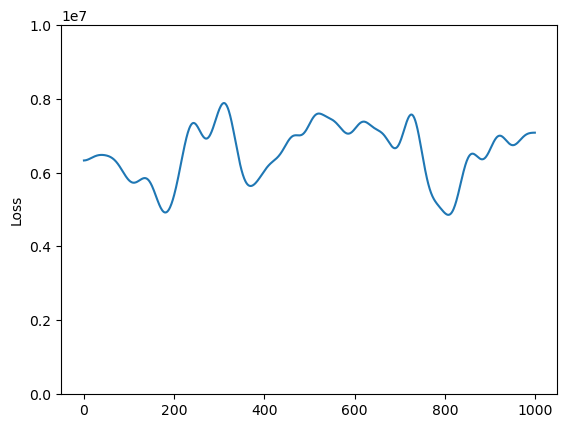

In [73]:
from scipy.ndimage import gaussian_filter1d
L = gaussian_filter1d(L, sigma=10)
plt.plot(L)
plt.ylim(0, 10000000)
plt.ylabel("Loss")